Load pre-computed activations from pickle files and compute SVD concentration of refusal directions.

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

In [ ]:
with open('data/results_BASE_refusal_on_AT.pkl', 'rb') as f:
    base_on_at = pickle.load(f)

with open('data/results_BASE_refusal_on_LAT.pkl', 'rb') as f:
    base_on_lat = pickle.load(f)

with open('data/results_LAT_refusal_on_AT.pkl', 'rb') as f:
    lat_on_at = pickle.load(f)

with open('data/results_LAT_refusal_on_BASE.pkl', 'rb') as f:
    lat_on_base = pickle.load(f)

print(f"Loaded {len(base_on_at)} layers")
print(f"Example run_id: {base_on_at[0]['run_id']}")
print(f"Keys: {base_on_at[0].keys()}")

Loaded 1 layers
Example run_id: at_n_samples_100.layer_14
Keys: dict_keys(['run_id', 'n_samples', 'layer', 'refusal_dir', 'harmful_acts', 'harmless_acts', 'baseline_completions', 'intervention_completions'])


In [ ]:
# computing activation differences per TARGET model
# base_on_at and lat_on_at both contain AT model activations -> identical diffs
base_on_at_diffs = base_on_at[0]['harmful_acts'] - base_on_at[0]['harmless_acts']   # AT model
base_on_lat_diffs = base_on_lat[0]['harmful_acts'] - base_on_lat[0]['harmless_acts'] # LAT model
lat_on_at_diffs = lat_on_at[0]['harmful_acts'] - lat_on_at[0]['harmless_acts']       # AT model
lat_on_base_diffs = lat_on_base[0]['harmful_acts'] - lat_on_base[0]['harmless_acts'] # BASE model

print(f"Layer: {base_on_at[0]['layer']}")
print(f"Diff shapes: {base_on_at_diffs.shape}, {lat_on_at_diffs.shape}")

Layer: 14
Diff shapes: (100, 4096), (100, 4096)


In [ ]:
def explained_variance_ratio(data):
    _, s, _ = svd(data, full_matrices=False)
    variance_ratio = (s**2) / np.sum(s**2)
    return variance_ratio

base_on_at_var = explained_variance_ratio(base_on_at_diffs)    # AT model
base_on_lat_var = explained_variance_ratio(base_on_lat_diffs)  # LAT model
lat_on_at_var = explained_variance_ratio(lat_on_at_diffs)      # AT model
lat_on_base_var = explained_variance_ratio(lat_on_base_diffs)  # BASE model

# paper fig 5/6 results (416 samples):
#   BASE: ~49% top-1, ~68% top-10
#   AT:   ~43% top-1, ~63% top-10
#   LAT:  ~51% top-1, ~74% top-2, ~83% top-10
#
# repro results (100 samples) - mapping by TARGET model:
#   AT model  (base_on_at, lat_on_at): 43.8% top-1 -> matches paper AT ~43%
#   LAT model (base_on_lat):           54.0% top-1, 74.6% top-2 -> matches paper LAT ~51%, ~74%
#   BASE model (lat_on_base):          49.4% top-1 -> matches paper BASE ~49%

print("SVD Component 1 Explained Variance:")
print(f"  BASE on AT:   {base_on_at_var[0]*100:.1f}%")
print(f"  BASE on LAT:  {base_on_lat_var[0]*100:.1f}%")
print(f"  LAT on AT:    {lat_on_at_var[0]*100:.1f}%")
print(f"  LAT on BASE:  {lat_on_base_var[0]*100:.1f}%")

print("\nTop 2 components:")
print(f"  BASE on AT:   {sum(base_on_at_var[:2])*100:.1f}%")
print(f"  BASE on LAT:  {sum(base_on_lat_var[:2])*100:.1f}%")
print(f"  LAT on AT:    {sum(lat_on_at_var[:2])*100:.1f}%")
print(f"  LAT on BASE:  {sum(lat_on_base_var[:2])*100:.1f}%")

SVD Component 1 Explained Variance:
  BASE on AT:   43.8%
  BASE on LAT:  54.0%
  LAT on AT:    43.8%
  LAT on BASE:  49.4%

Top 2 components:
  BASE on AT:   48.6%
  BASE on LAT:  74.6%
  LAT on AT:    48.6%
  LAT on BASE:  54.2%


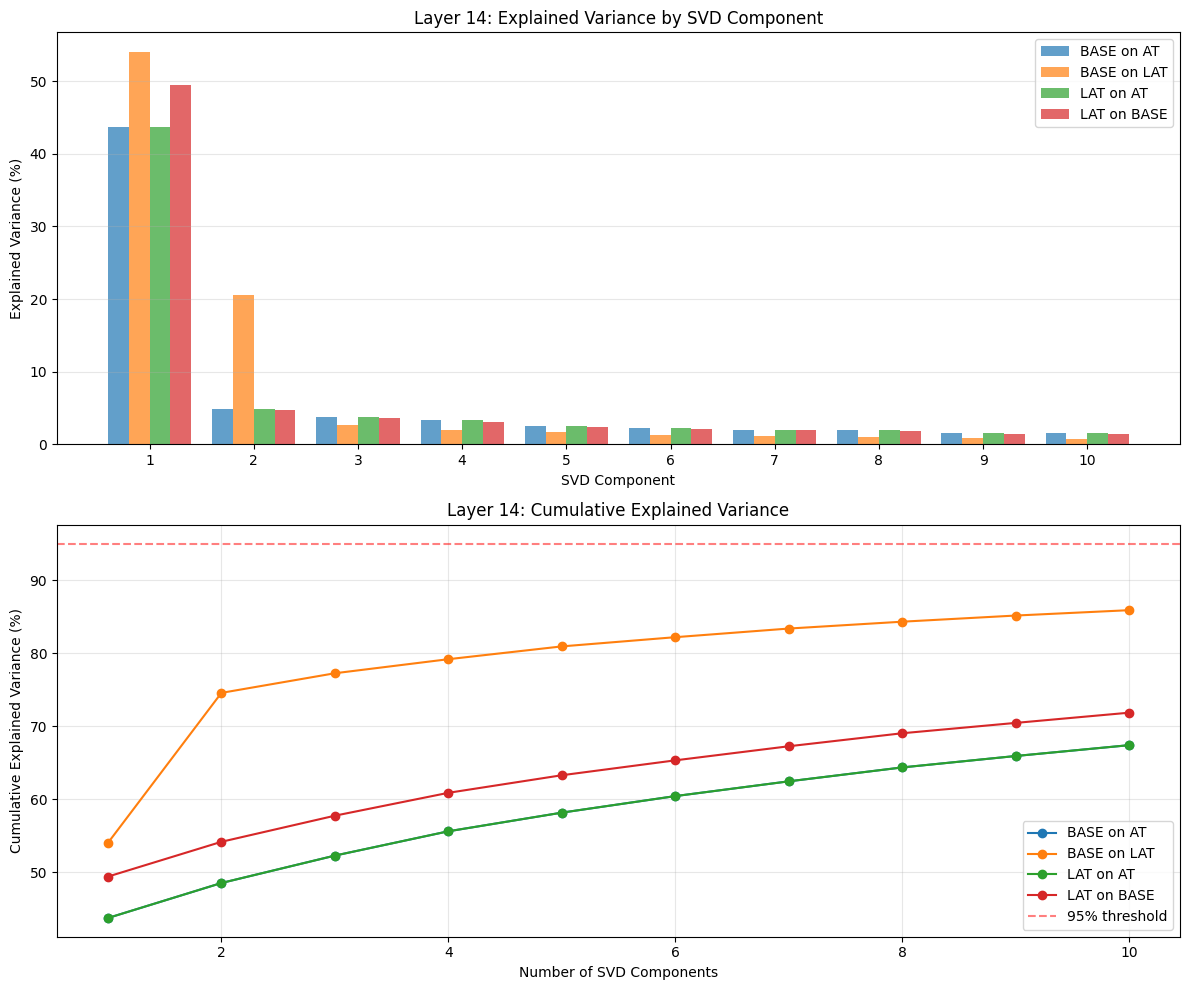

In [ ]:
# BASE on LAT = LAT model geometry, etc.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

n_components = 10
x = np.arange(n_components)
width = 0.2

ax1.bar(x - 1.5*width, base_on_at_var[:n_components] * 100, width, label='BASE on AT', alpha=0.7)
ax1.bar(x - 0.5*width, base_on_lat_var[:n_components] * 100, width, label='BASE on LAT', alpha=0.7)
ax1.bar(x + 0.5*width, lat_on_at_var[:n_components] * 100, width, label='LAT on AT', alpha=0.7)
ax1.bar(x + 1.5*width, lat_on_base_var[:n_components] * 100, width, label='LAT on BASE', alpha=0.7)

ax1.set_xlabel('SVD Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title(f'Layer 14: Explained Variance by SVD Component')
ax1.set_xticks(x)
ax1.set_xticklabels(range(1, n_components + 1))
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

ax2.plot(range(1, n_components+1), np.cumsum(base_on_at_var[:n_components]) * 100, 'o-', label='BASE on AT')
ax2.plot(range(1, n_components+1), np.cumsum(base_on_lat_var[:n_components]) * 100, 'o-', label='BASE on LAT')
ax2.plot(range(1, n_components+1), np.cumsum(lat_on_at_var[:n_components]) * 100, 'o-', label='LAT on AT')
ax2.plot(range(1, n_components+1), np.cumsum(lat_on_base_var[:n_components]) * 100, 'o-', label='LAT on BASE')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')

ax2.set_xlabel('Number of SVD Components')
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_title(f'Layer 14: Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def components_for_threshold(var_ratio, threshold=0.95):
    cumsum = np.cumsum(var_ratio)
    return np.argmax(cumsum >= threshold) + 1

print("Components needed for 95% explained variance:")
print(f"  BASE on AT:   {components_for_threshold(base_on_at_var)}")
print(f"  BASE on LAT:  {components_for_threshold(base_on_lat_var)}")
print(f"  LAT on AT:    {components_for_threshold(lat_on_at_var)}")
print(f"  LAT on BASE:  {components_for_threshold(lat_on_base_var)}")

# paper fig 6 top-10: BASE ~68%, AT ~63%, LAT ~83%
# repro: AT 67.4%, LAT 85.9%, BASE 71.9% - matches pattern
print("\nTotal variance in top 10 components:")
print(f"  BASE on AT:   {sum(base_on_at_var[:10])*100:.1f}%")
print(f"  BASE on LAT:  {sum(base_on_lat_var[:10])*100:.1f}%")
print(f"  LAT on AT:    {sum(lat_on_at_var[:10])*100:.1f}%")
print(f"  LAT on BASE:  {sum(lat_on_base_var[:10])*100:.1f}%")

Components needed for 95% explained variance:
  BASE on AT:   67
  BASE on LAT:  39
  LAT on AT:    67
  LAT on BASE:  62

Total variance in top 10 components:
  BASE on AT:   67.4%
  BASE on LAT:  85.9%
  LAT on AT:    67.4%
  LAT on BASE:  71.9%
